# CSCI-UA 0473 - Introduction to Machine Learning
## HW 2 - Programming Assignments

## Assignment 4 - Recovering Input (10 points)
For this programming assignment, an image (vector) was chosen and was passed through a weird function to obtain something mysterious (vector). 

You are given the mysterious vector and the weird function used to transform the original image. 

AND, YOUR TASK IS TO FIND THE ORIGINAL IMAGE.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plot
import matplotlib.cm as cm
from autograd import numpy
from autograd import grad

from scipy import optimize
import scipy

In [3]:
# The mysterious vector

import pickle    # Library used to save and load values of variables (Technically, it's called Serialization)

shp_original_img = (100, 100)  # Shape of the original image
mysterious_image = pickle.load(open('mysterious_image_t.p', 'rb'), encoding='latin1') # mysterious_image is a vector representing the morphed image

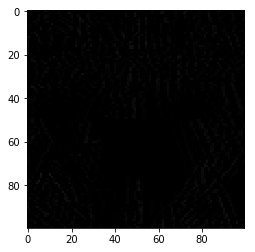

In [4]:
plot.imshow(mysterious_image.reshape(shp_original_img), cmap='gray', vmin=0, vmax=1)

In [5]:
# The weird function which transformed the original image
# x: a 1D array with 10000 elements.
def weird_function(x, n_iter=5):
    h = x    
    filt = numpy.array([-1./3, 1./3, -1./3])
    
    for ii in range(n_iter):
        h_l = numpy.concatenate([numpy.array([0]), h[:-1]])
        h_r = numpy.concatenate([h[1:], numpy.array([0])])
        h = filt[0] * h + filt[-1] * h_l + filt[1] * h_r
        
        if numpy.mod(ii, 2) == 0:
            h = numpy.concatenate([h[h.shape[0]//2:],h[:h.shape[0]//2]])
            
    return h

<div class="alert alert-danger">
Please write your implementation to find the original image and store it in the `original_image` variable.
</div>

<div class="alert alert-info">
**Hints**: <ul>
    <li> Can you reformulate this as an optimization problem?  If so, <ul>
<li> You will find `autograd` helpful. </li>
<li> Also, if you used `scipy.optimize.minimize()` in your solution and found your program slow, try passing the argument `method='CG'`. </li>
        </ul> </li>
    </ul>
</div>

In [14]:
def lost(x):
    return numpy.sum(numpy.square(weird_function(x)-mysterious_image))

grd=grad(lost)

def obj(x):
    return lost(x),grd(x)

In [15]:
# YOUR CODE HERE
image_init=numpy.random.rand(100,100)*256
res=scipy.optimize.minimize(obj,image_init,method='CG',jac=True)
res

     fun: 0.0004950664123851948
     jac: array([  1.26278288e-06,   1.42964239e-06,   1.69275380e-06, ...,
         1.84936153e-06,  -1.69766202e-06,  -1.60950389e-06])
 message: 'Optimization terminated successfully.'
    nfev: 1622
     nit: 445
    njev: 1622
  status: 0
 success: True
       x: array([ 0.9021575 ,  0.80452737,  0.55622982, ...,  0.04274001,
        0.05332593,  0.02980626])

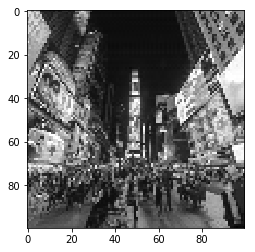

In [16]:
# This call will show something reasonable if your code is correct.
plot.imshow(res.x.reshape(shp_original_img), cmap='gray', vmin=0, vmax=1)

## Assignment 5 - Numerical Stability (10 points)

In Lab 3 we found that the logistic regression implementation is not numerically stable.  In particular, the gradient computation would yield NaN values given inputs with a large magnitude.

In this assignment, your goal is to re-implement logistic regression in a numerically stable way.

#### 0. Numerical stability analysis of negative log probability

<div class="alert alert-warning">
**Beware**: Although you don't have to write anything for this section, please read it to figure out where numerical stability issues would occur.  Such analysis is likely required for almost all scientific computation code if you write your own, regardless of platforms and programming languages.
</div>

Recall that the empirical cost function for logistic regression is an average of per-sample loss functions, each of which is the negative log probability of the correct label for a given sample:

$$
D_\mathrm{lr}(y_i, M, \mathbf{x}_i) = -y_i \log \mathrm{sigmoid}(\mathbf{w}^T \mathbf{x} + b) - (1 - y_i) \log (1 - \mathrm{sigmoid}(\mathbf{w}^T \mathbf{x} + b))
$$

where

$$
\mathrm{sigmoid}(x) = \dfrac{1}{1 + \exp (-x)}
$$

We can see that a naive implementation would have two potential stability issues:
1. If $\mathrm{sigmoid}(\mathbf{w}^T \mathbf{x} + b))$ is either close to 0 or 1, then one of the logarithm terms in the first equation will give us $-\infty$.
2. If $x$ is negative with a large enough absolute value, then $\exp(-x)$ in the second equation will become $+\infty$.

#### 1. Rewriting the negative log probability

After the identification of stability issues, the first thing we usually try is to rewrite the entire formulation in order to avoid most of the issues *while* maintaining precision as much as possible.

Suppose that we have a numerically stable implementation of a *log-sigmoid* function.  It is possible to express the per-sample loss function (hence the empirical cost function itself)
* Using `log_sigmoid()`, and
* Without using either `numpy.log()` or `numpy.exp()` outside `log_sigmoid()`.

<div class="alert alert-danger">
Please fill in (1) the implementation of a numerically stable `log_sigmoid()` function, and (2) the implementation of `logreg_cost` to compute the *empirical cost function* of logistic regression, using `log_sigmoid()` but without using `numpy.log()` and `numpy.exp()` elsewhere.  You don't have to give the mathematical derivation for your implementation.
</div>

<div class="alert alert-info">
**Hint**: The derivation of the more numerically stable negative log probability for a *single* sample goes as follows:
<ol>
    <li> Denote $s = \mathbf{w}^T \mathbf{x} + b$. </li>
    <li> Rewrite the per example loss with $\log \mathrm{sigmoid}(s)$ as a whole term, without any other logarithms or exponentials. </li>
    <li> Now take a look at $\log \mathrm{sigmoid}(s) = \log \frac{1}{1 + \exp(-s)}$.  We don't have any problem computing this quantity with a positive $s$, but how do we avoid overflow when $s$ is negative with a large magnitude?  (Hint: re-express this quantity using $\log \mathrm{sigmoid}(-s)$).  How do we combine both cases together in `numpy`? </li>
    <li> For positive $s$, rewrite $\log \mathrm{sigmoid}(s)$ to eliminate the fraction inside the logarithm.  Use `numpy.log1p()` to compute the quantity $\log (1 + x)$ since it avoids underflow with small $x$.
</ol><br>
The procedure above for computing a more precise $\log \mathrm{sigmoid}(x)$ is a special case of the more general *log-sum-exp* trick, which is the basis of the numerical stability for multiclass logistic regression (which will be covered later in the course).
</div>

In [11]:
def log_sigmoid_naive(s):
    # DO NOT CHANGE
    return numpy.log(1 / (1 + numpy.exp(-s)))

def log_one_minus_sigmoid_naive(s):
    # DO NOT CHANGE
    return numpy.log(1 - 1 / (1 + numpy.exp(-s)))

def logreg_cost_naive(params, x, y):
    # DO NOT CHANGE
    w, b = params[:-1], params[-1]
    s=numpy.dot(x,w)+b
    return numpy.mean(-y * log_sigmoid_naive(s) - (1 - y) * log_one_minus_sigmoid_naive(s))

def log_sigmoid(s):
    # YOUR CODE HERE: rewrite this function in a numerically stable way.
    s1=numpy.maximum(s,0)
    s2=numpy.minimum(s,0)
    ans=-numpy.log1p(numpy.exp(-s1))+(s2-numpy.log1p(numpy.exp(s2)))+numpy.log1p(numpy.exp(0)) 
    #the last term because the vector has repetition on 0 for max and min, so just minus one to get it right
    return ans
    
def logreg_cost(params, x, y):
    # YOUR CODE HERE: rewrite the cost function.
    # y: a 1D array of 0-1 labels with shape (n_samples,)
    # x: a 2D array (matrix) with shape (n_samples, n_features).  Each row contains an input vector.
    # params: a 1D array of logistic regression parameters, with shape (n_samples + 1,)
    w, b = params[:-1], params[-1]
    s=numpy.dot(x,w)+b
    return numpy.mean(-y*log_sigmoid(s)-(1-y)*(-s+log_sigmoid(s)))

The following cell consists of two tests which ensures that
* your solution is close to the naive solution for "normal" numbers, and
* your solution would not throw NaNs in either cost or gradient computation for large numbers.

<div class="alert alert-warning">
**Beware**: Passing the two tests does **NOT** necessarily mean that your code is correct.  For instance, you can easily pass these tests with a solution that calls the naive functions for "normal" values, and always return 0 for large values.
</div>

In [20]:
from sklearn.datasets import make_blobs

# Tests for correctness
# DO NOT CHANGE

logreg_rule = grad(logreg_cost)
logreg_rule_naive = grad(logreg_cost_naive)
n_features = 10
n_samples = 100

def test(scale, normal):
    # Throws an error if the test fails
    center_positive = numpy.ones(n_features) * scale
    center_negative = -numpy.ones(n_features) * scale
    std = scale
    for _ in range(10):
        # Since we don't really care about classification itself, we just randomly generate a bunch of params, x's and y's.
        params = numpy.random.randn(n_features + 1)
        params[-1] = 0
        x, y = make_blobs(n_samples=n_samples,
                          n_features=n_features,
                          centers=[center_positive, center_negative], cluster_std=std, shuffle=True)

        cost = logreg_cost(params, x, y)
        dcost_dparams = logreg_rule(params, x, y)
        
        if normal:
            cost_naive = logreg_cost_naive(params, x, y)
            dcost_dparams_naive = logreg_rule_naive(params, x, y)
            # Throws an error if the two arrays differ significantly
            print cost
            print cost_naive
            assert numpy.allclose(cost, cost_naive)
            assert numpy.allclose(dcost_dparams, dcost_dparams_naive)
        else:
            assert not numpy.isnan(cost) and not numpy.isinf(cost)
            assert not numpy.any(numpy.isnan(dcost_dparams) | numpy.isinf(dcost_dparams))
            cost_naive = logreg_cost_naive(params, x, y)
            print cost
            print cost_naive
        print "-----"
    
# Precision test: your solution should be close to the naive solution for "normal" numbers.
print "---normal test---"
test(1, True)
# Stability test: your solution should not throw NaN in either the cost or gradient computation for large numbers.
print "---stability test---"
test(10000, False)

---normal test---
2.03774656258
2.03774656258
-----
6.69786976799
6.69786976799
-----
1.25643200844
1.25643200844
-----
1.50740598858
1.50740598858
-----
1.0777758893
1.0777758893
-----
0.0595785713036
0.0595785713036
-----
1.82017051633
1.82017051633
-----
1.76229236741
1.76229236741
-----
1.55781804595
1.55781804595
-----
1.50754968025
1.50754968025
-----
---stability test---
4480.63312967
nan
-----
1082.89112749
nan
-----
6561.68576317
nan
-----
5382.14573303
nan
-----
8992.91908654
nan
-----
18518.1691171
nan
-----
315.297978162
nan
-----
26475.0645401
nan
-----
48215.5085529
nan
-----
23844.4322965
nan
-----


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
